# Indiana Pines

1. Import dependencies

In [ ]:
import random
import torch
import multiprocessing
import numpy as np
import torch.utils.data as data

from sklearn.model_selection import train_test_split
from lightning import Trainer
from torch.optim.lr_scheduler import StepLR

from src.util.torch import resolve_torch_device
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    PreProcessType,
    DimReductionType,
)
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.lenet import FullyConvolutionalLeNet
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_numbers_distribution,
    plot_epoch_generic_comparison,
    plot_epoch_generic,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.util.reporting import create_model_name, report_run, read_report_to_show, lightning_metrics
from src.util.list_ext import smooth_moving_average

2. Prepare env

In [2]:
learning_rate = 1e-3
num_epochs = 1000
scheduler_step_size = num_epochs // 10
scheduler_gamma = 0.9

In [ ]:
batch_size = 32
patch_size = 9
target_dim = 75

pre_process_type = PreProcessType.NORMALIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.set_float32_matmul_precision("medium")

In [7]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [8]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [9]:
_, image = preprocess_hsi(image, pre_process_type)

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
num_classes = len(np.unique(y))

f"Number of classes {num_classes}"

'Number of classes 17'

In [13]:
examples_per_class = [20] * num_classes

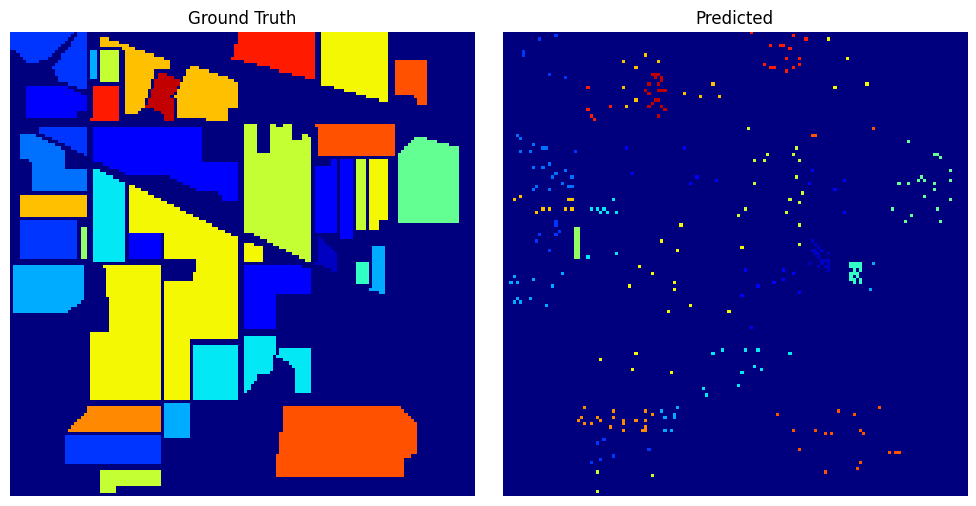

In [ ]:
if examples_per_class:
    x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
        x, y, examples_per_class, "indian_pines"
    )

    plot_segmentation_comparison(
        y.reshape(image_h, image_w), y_masked.reshape(image_h, image_w), title2="Masked"
    )
else:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=random_seed, stratify=y
    )

# plot_numbers_distribution(y_train, desc="Train class distribution")

In [15]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [16]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

In [17]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [18]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

4. Train model

In [ ]:
model = HyperSpectralImageClassifier(
    FullyConvolutionalLeNet(target_dim, num_classes),
    num_classes,
    lr=learning_rate,
    scheduler=lambda opt: StepLR(
        opt, step_size=scheduler_step_size, gamma=scheduler_gamma
    ),
)

trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
trainer.fit(
    model,
    train_loader,
    # test_loader,
)

/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params | Mode 
---------------------------------------------------------------------
0 | net              | FullyConvolutionalLeNet | 309 K  | train
1 | f1               | MulticlassF1Score       | 0      | train
2 | overall_accuracy | MulticlassAccuracy      | 0      | train
3 | average_accuracy | MulticlassAccuracy      | 0      | train
4 | kappa            | MulticlassCohenKappa    | 0      | train
---------------------------------------------------------------------
309 K     Trainable params
0         Non-trainable params
309 K     Total params
1.240     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
/home/melal/W

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


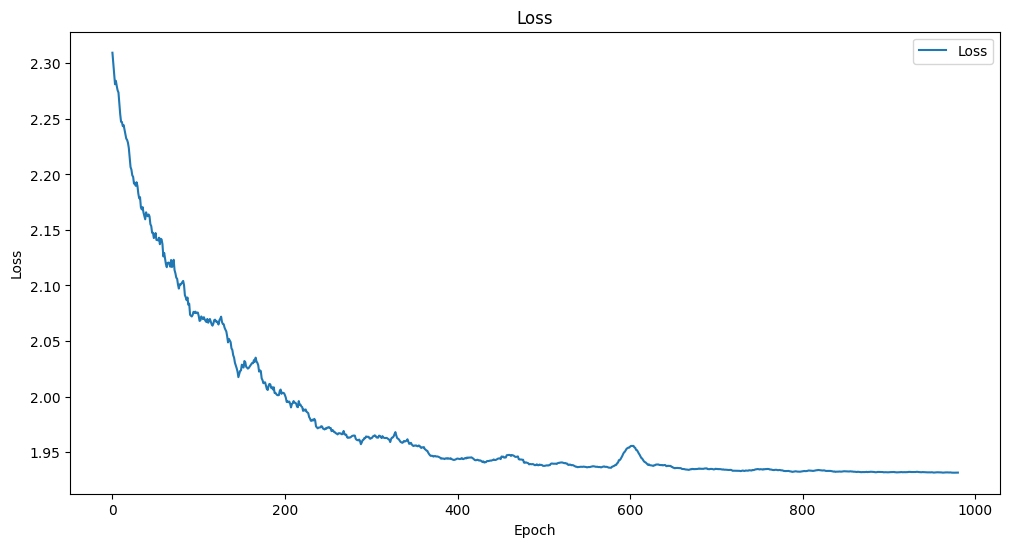

In [21]:
smothed_train = smooth_moving_average([it.loss.cpu() for it in model.train_metrics], 20)
# smothed_eval = smooth_moving_average([it.loss.cpu() for it in model.val_metrics], 20)

# plot_epoch_generic_comparison(smothed_train, smothed_eval)

plot_epoch_generic(smothed_train)

In [22]:
# smooth_f1 = smooth_moving_average([it.f1.cpu() for it in model.val_metrics], 20)

# plot_epoch_generic(smooth_f1)

In [23]:
validation_result = trainer.validate(model, full_loader)

validation_result

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.4493222236633301
         val_f1             0.46152985095977783
        val_kappa                   nan
        val_loss             2.487203598022461
  val_overall_accuracy      0.2653588652610779
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.487203598022461,
  'val_f1': 0.46152985095977783,
  'val_overall_accuracy': 0.2653588652610779,
  'val_average_accuracy': 0.4493222236633301,
  'val_kappa': nan}]

5. Display prediction

In [24]:
y_pred = trainer.predict(model, predict_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [25]:
y_pred = torch.cat(y_pred, dim=0)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

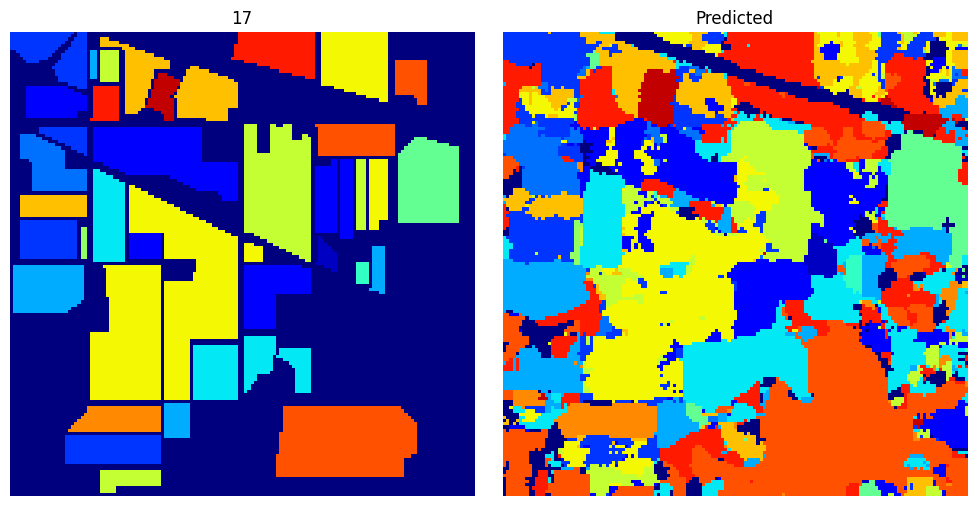

In [26]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)

6. Write report

In [27]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "lenet"

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="More epochs, PCA, norm, scheduler and smaller patch size",
    run_params={
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "patch_size": patch_size,
        "target_dim": target_dim,
        "scheduler_step_size": scheduler_step_size,
        "scheduler_gamma": scheduler_gamma,
        "pre_process_type": str(pre_process_type),
        "dim_reduction_type": str(dim_reduction_type),
    },
    run_metrics=lightning_metrics(validation_result),
)

PosixPath('/home/melal/Workspace/spatial-regulated-self-training/reports/runs/indian_pines__2020202020202020202020202020202020.csv')

In [28]:
read_report_to_show(model_name, sort_by_metric="f1")

,timestamp,model_category,run_desc,params,loss,f1,OA,AA,kappa
21,2025-05-25T13:49:18.465537+00:00,specteal_former,"With scheduling, incresed dropout and weight d...","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.709462,0.629933,3.285941e-01,0.592009,0.428213
19,2025-05-25T13:11:09.295934+00:00,specteal_former,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.884388,0.610363,3.212764e-01,0.573888,0.418024
29,2025-05-25T20:53:11.217368+00:00,facto_former,"Add PCA, and dropout","{""spatial_embed_dim"": 64, ""spectral_embed_dim""...",2.707989,0.606260,2.905328e-01,0.565232,0.399181
26,2025-05-25T20:32:27.231494+00:00,facto_former,Default run,"{""spatial_embed_dim"": 64, ""spectral_embed_dim""...",2.480875,0.605703,3.172534e-01,0.563092,0.405921
30,2025-05-25T20:56:33.371563+00:00,facto_former,Add PCA and more dropout,"{""spatial_embed_dim"": 64, ""spectral_embed_dim""...",2.790326,0.600878,2.908698e-01,0.559477,0.393422
17,2025-05-25T12:28:13.957191+00:00,specteal_former,With scheduling,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.039043,0.588829,3.162847e-01,0.557241,0.407733
28,2025-05-25T20:51:22.895522+00:00,facto_former,"Add PCA, and dropout","{""spatial_embed_dim"": 64, ""spectral_embed_dim""...",2.768773,0.588547,2.797896e-01,0.550725,0.390024
18,2025-05-25T12:48:49.301608+00:00,specteal_former,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.218621,0.575685,3.045633e-01,0.548062,0.399809
27,2025-05-25T20:49:26.036093+00:00,facto_former,Add PCA,"{""spatial_embed_dim"": 64, ""spectral_embed_dim""...",2.720715,0.574609,2.798136e-01,0.538835,0.382495
16,2025-05-25T11:54:50.924387+00:00,specteal_former,Default run,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.187469,0.560617,2.933610e-01,0.531653,0.385957


In [ ]:
read_report_to_show(model_name, sort_by_metric="OA", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
6,2025-05-24T23:39:51.672671+00:00,"More epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.497706,0.462771,2.424388e+33,0.457883,NaN
8,2025-05-25T00:13:59.916485+00:00,"A lot more epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 1000, ""...",2.457449,0.489860,2.897493e-01,0.478478,NaN
7,2025-05-25T00:11:16.070258+00:00,"More epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.513368,0.472783,2.816274e-01,0.463876,NaN
3,2025-05-24T20:55:14.129875+00:00,Default run (more epochs and PCA),"{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.496867,0.468382,2.811697e-01,0.461641,NaN
15,2025-05-25T11:31:53.271370+00:00,"More epochs, PCA, norm, and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 1000, ""...",2.469688,0.473372,2.799799e-01,0.462592,NaN
31,2025-05-25T21:07:44.655094+00:00,"More epochs, PCA, norm, scheduler and smaller ...","{""learning_rate"": 0.001, ""num_epochs"": 1000, ""...",2.487204,0.461530,2.653589e-01,0.449322,NaN
5,2025-05-24T22:22:51.497627+00:00,More epochs and PCA with whiten False,"{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.522240,0.461525,2.551436e-01,0.444233,NaN
4,2025-05-24T21:44:16.017235+00:00,Default run (more epochs and PCA),"{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.533018,0.439027,2.516287e-01,0.430059,NaN
2,2025-05-24T20:10:50.695790+00:00,Default run (more epochs),"{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.519917,0.471948,2.376698e-01,0.444376,NaN
1,2025-05-24T19:21:48.509234+00:00,Default run (more epochs),"{""learning_rate"": 0.001, ""num_epochs"": 100, ""b...",2.559524,0.489064,2.364114e-01,0.443092,NaN
